In [1]:
import torch
import torch.nn as nn
import numpy as np
from time import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import scipy.io as sio
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.data import DataLoader
from utils.datasets import video_loader, mario_loader
from utils.model import Layer_FISTA
from utils.model import Shrinkage_Layer

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [56]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.completeness_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=500,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.4f}\t{:.4f}\t{:.4f}"#\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results

def compute_scores(U, dim, labels):
    U = U[0].cpu().numpy()
    #print(U.shape)
    U = np.mean(np.abs(U), axis=1)

    U_flat = np.zeros((U.shape[-1], U.shape[0] * U.shape[1]))
    for i in range(U.shape[-1]):
        U_flat[i, :] = U[:,:,:,i].flatten()
    #print(U_flat.shape)

    pca = PCA(n_components=dim)
    U_new_F_PCA = pca.fit_transform(U_flat)
    kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
    
    result = bench_k_means(kmeans=kmeans, name="k-means++", data=U_new_F_PCA, labels=labels)
    return result


# Compare Mario Dataset

In [52]:
loader = DataLoader(mario_loader('data/mario_video_test.npy'), batch_size=1, shuffle=False, num_workers=1)
labels = [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100 + [4] * 100

In [53]:
FISTA = Layer_FISTA(n_ch=3, lam=0.5, gamma0=1., mu=0.01/150, beta=0.5, X_dim=300, U_dim=40, patch_size=16, 
                     input_size=40, isTopLayer=True, n_steps=50)
FISTA.to(device)
FISTA.load_state_dict(torch.load('runs/FISTA/mario/layer1.pth.tar'))
FISTA.eval()

Layer_FISTA()

In [54]:
Shrinkage = Shrinkage_Layer(n_ch=3, lam=0.5, gamma0=0.3, mu=0.3, beta=0.5, n_u=100)
Shrinkage.to(device)
Shrinkage.load_state_dict(torch.load('runs/shrinkage/mario/layer1.pth.tar'))
Shrinkage.eval()

Shrinkage_Layer()

In [59]:
acc_F, acc_S = [], []
ari_F, ari_S = [], []
with torch.no_grad():
    for _, data in enumerate(loader):
        data = data.to(torch.float32).to(device)
        X_F, U_F = FISTA.inference(data)
        X_S, U_S = Shrinkage.inference(data)
        
        print("init\t\ttime\tinertia\tcompl\tARI\tss")
        result_F = compute_scores(U_F, 2, labels)
        result_S = compute_scores(U_S, 2, labels)
        print()
        
        acc_F.append(result_F[-3])
        acc_S.append(result_S[-3])
        
        ari_F.append(result_F[-2])
        ari_S.append(result_S[-2])
        
print("FISTA ACC:", np.mean(acc_F), "FISTA ARI:", np.mean(ari_F))
print("Shrinkage ACC:", np.mean(acc_S), "Shrinkage ARI:", np.mean(ari_S))

KeyboardInterrupt: 

In [58]:
print("init\t\ttime\tinertia\tcompl\tARI\tss")
result_F = compute_scores(U_F, 2, labels)
result_S = compute_scores(U_S, 2, labels)

init		time	inertia	compl	ARI	ss
k-means++	0.003s	10	0.8875	0.8685	0.6638
k-means++	0.003s	14	0.9652	0.9750	0.8665


In [45]:
dim = 2

In [46]:
labels = [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100 + [4] * 100

U_np_F = U_F[0].cpu().numpy()
print(U_np_F.shape)
U_np_F = np.mean(U_np_F, axis=1)
print(U_np_F.shape)

U_new_F = np.zeros((U_np_F.shape[-1], U_np_F.shape[0] * U_np_F.shape[1]))
for i in range(U_np_F.shape[-1]):
    U_new_F[i, :] = U_np_F[:,:,:,i].flatten()
print(U_new_F.shape)

pca = PCA(n_components=dim)
U_new_F_PCA = pca.fit_transform(U_new_F)
kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
print("init\t\ttime\tinertia\tcompl\tARI\tss")
result_F = bench_k_means(kmeans=kmeans, name="k-means++", data=U_new_F_PCA, labels=labels)


(3, 1, 40, 1, 500)
(3, 40, 1, 500)
(500, 120)
init		time	inertia	compl	ARI	ss
k-means++	0.003s	10	0.8875	0.8685	0.6638


In [47]:
U_np_S = U_S[0].cpu().numpy()
U_np_S = np.mean(U_np_S, axis=1)
print(U_np_S.shape)

U_new_S = np.zeros((U_np_S.shape[-1], U_np_S.shape[0] * U_np_S.shape[1]))
for i in range(U_np_S.shape[-1]):
    U_new_S[i, :] = U_np_S[:,:,:,i].flatten()
print(U_new_S.shape)
pca = PCA(n_components=dim)
U_new_S_PCA = pca.fit_transform(U_new_S)
kmeans1 = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
print("init\t\ttime\tinertia\tcompl\tARI\tss")
result_S = bench_k_means(kmeans=kmeans1, name="k-means++", data=U_new_S_PCA, labels=labels)

(3, 40, 1, 500)
(500, 120)
init		time	inertia	compl	ARI	ss
k-means++	0.003s	14	0.9583	0.9700	0.8647


In [49]:
result_F
result_S

['k-means++',
 0.0025277137756347656,
 13.915712961770728,
 0.9582666279628529,
 0.9699875876844822,
 0.8647439562664508]

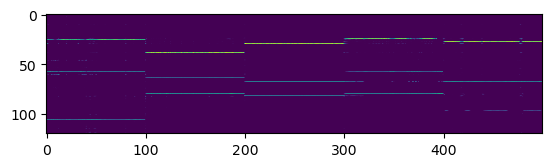

In [10]:
plt.imshow(U_new_S.T)

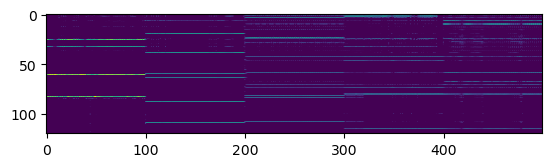

In [11]:
plt.imshow(U_new_F.T)